In [1]:
# https://keras.io/examples/vision/pointnet/
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
##############################
import wandb
import datetime
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(1234)

## Load dataset

In [2]:
# Download ModelNet10 dataset
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [3]:
# trimesh package can be used to visualize .off mesh files
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

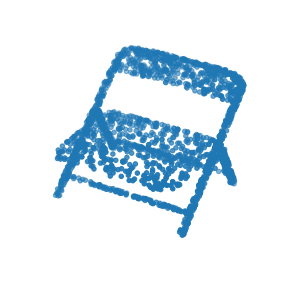

In [4]:
# Sample 2048 points from mesh surface to get pointcloud
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [5]:
# Generate tf.data.Dataset()
def parse_dataset(num_points=2048):
    
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [6]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: night_stand
processing class: monitor
processing class: desk
processing class: chair
processing class: bed
processing class: toilet
processing class: sofa
processing class: dresser
processing class: bathtub
processing class: table


In [7]:
# Read data into tf.data.Dataset() object
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Build a model

In [8]:
# Basic classes for convolution/dense layers
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [9]:
# Custom activity regularizer for penalization of layer activity during training (the penalties are summed into the loss function that the network optimizes)
# Purpose of the regularizator: constrains the feature transformation matrix (T-Net output) to be close to orthogonal matrix (the optimization also becomes more stable this way)
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))       # axis=1 is equivalent to matrix multiplication
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {
            'num_features': self.num_features,
            'l2reg': self.l2reg
        }

In [10]:
# T-Net implementation (NOTE: there's only half the number of weights at each layer as we are using the smaller 10 class)
def tnet(inputs, num_features):
    
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [11]:
# PointNet implementation, again with half the number of weights at each layer
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

## Train model

In [12]:
# Train the model
EPOCHS = 20
lr = 0.001

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["sparse_categorical_accuracy"],
)

# Train with WandB callbacks
wandb_config = {
    'model': 'PointNet-Mini',
    'num_points': NUM_POINTS,
    'num_classes': NUM_CLASSES,
    'batch_size': BATCH_SIZE,
    'optimizer': 'Adam',
    'learning_rate': lr
}

# WandB init
run = wandb.init(
    project='CorsNet', 
    reinit=True,
    config=wandb_config
)

# Set the run name to the run ID
wandb.run.name = 'PointNet-Mini-' + wandb.run.id

# Model checkpoint callback
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
checkpoint_dir = os.path.join('..', 'models', timestamp + "_%s" % wandb.run.name)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model.epoch{epoch:02d}.h5'), 
    monitor='val_sparse_categorical_accuracy',
    verbose=0, 
    save_best_only=True,
    mode='max')

# Finally fit
model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, 
    callbacks=[WandbCallback(), checkpoint], verbose=1)

run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katkaj (use `wandb login --relogin` to force relogin)


Epoch 1/20
125/125 [==============================] - 53s 390ms/step - loss: 3.5322 - sparse_categorical_accuracy: 0.2731 - val_loss: 7188221.5000 - val_sparse_categorical_accuracy: 0.1267
Epoch 2/20
125/125 [==============================] - 47s 373ms/step - loss: 3.0204 - sparse_categorical_accuracy: 0.3789 - val_loss: 23645824336527360.0000 - val_sparse_categorical_accuracy: 0.3877
Epoch 3/20
125/125 [==============================] - 46s 370ms/step - loss: 2.8178 - sparse_categorical_accuracy: 0.4515 - val_loss: 8841354805248.0000 - val_sparse_categorical_accuracy: 0.4857
Epoch 4/20
125/125 [==============================] - 47s 373ms/step - loss: 2.6053 - sparse_categorical_accuracy: 0.5425 - val_loss: 127.5995 - val_sparse_categorical_accuracy: 0.3888
Epoch 5/20
125/125 [==============================] - 44s 353ms/step - loss: 2.4617 - sparse_categorical_accuracy: 0.5775 - val_loss: 2801975296.0000 - val_sparse_categorical_accuracy: 0.4570
Epoch 6/20
125/125 [====================

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁
sparse_categorical_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇███████
val_loss,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▄▄▆▇▇▆▇▆██▅██▇▇██
best_epoch,13
best_val_loss,2.33791
epoch,19
loss,1.60594
sparse_categorical_accuracy,0.83087
val_loss,3534910914560.0


## Visualize predictions

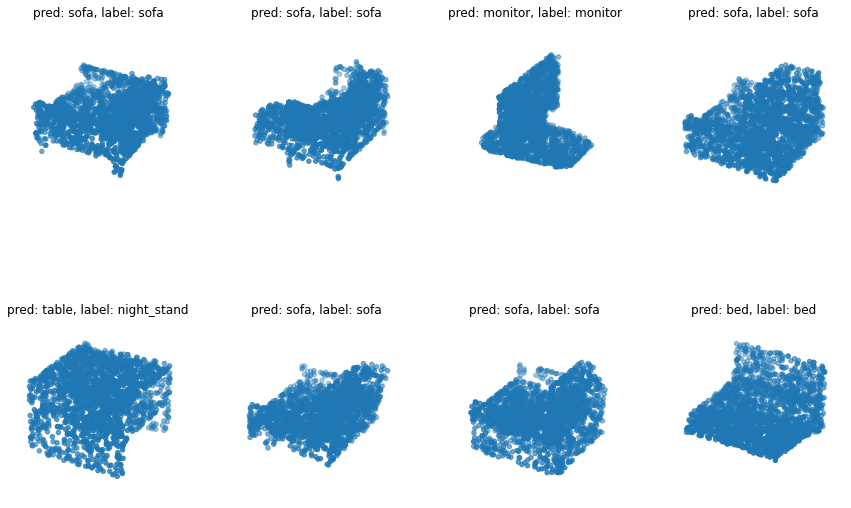

In [13]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# Run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# Plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()